In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa as lr
import librosa.display
from IPython.display import Audio
import warnings
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras.models import model_from_json
from keras.utils import to_categorical
import noisereduce as nr
%matplotlib inline

import os

Using TensorFlow backend.
/home/gega/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
warnings.filterwarnings("ignore")

In [3]:
SR = 16000
n_mfcc = 10

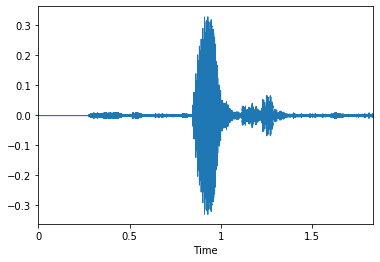

In [4]:
audio, sr = lr.load("./data/1/devi-khos-1a.wav", mono=True, sr=SR)
time = np.arange(0, len(audio)) / sr
plt.figure()
librosa.display.waveplot(audio, sr=sr)

In [5]:
Audio(audio, rate=SR)

In [6]:
def add_noise(data):
        noise = np.random.randn(len(data))
        data_noise = data + 0.003 * noise
        return data_noise

In [7]:
def shift(data):
        y_shift = data.copy()
        timeshift_fac = 0.2 *2*(np.random.uniform()-0.5)  # up to 20% of length
        
        start = int(y_shift.shape[0] * timeshift_fac)
        if (start > 0):
            y_shift = np.pad(y_shift,(start,0),mode='constant')[0:y_shift.shape[0]]
        else:
            y_shift = np.pad(y_shift,(0,-start),mode='constant')[0:y_shift.shape[0]]
        return y_shift

In [8]:
def stretch(data, rate=1):
        input_length = len(data)
        streching = data.copy()
        streching = librosa.effects.time_stretch(streching.astype('float'), 1.05)
        if len(streching) > input_length:
            streching = streching[:input_length]
        else:
            streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
        
        return streching

In [9]:
def pitch_and_speed(data):
    y_pitch_speed = data.copy()
    length_change = np.random.uniform(low=0.9, high = 1.1)
    speed_fac = 1.0  / length_change
    
    tmp = np.interp(np.arange(0,len(y_pitch_speed),speed_fac),np.arange(0,len(y_pitch_speed)),y_pitch_speed)
    minlen = min(y_pitch_speed.shape[0], tmp.shape[0])
    y_pitch_speed *= 0
    y_pitch_speed[0:minlen] = tmp[0:minlen]
    return y_pitch_speed

In [10]:
def pitch(data):
    y_pitch = data.copy()
    bins_per_octave = 12
    pitch_pm = 1.07
    pitch_change =  pitch_pm * 2 *(np.random.uniform())   
    y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), 
                                          sr, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
    return y_pitch

In [11]:
def speed(data):
    y_speed = data.copy()
    speed_change = np.random.uniform(low=0.95,high=1.05)
    
    tmp = librosa.effects.time_stretch(y_speed.astype('float64'), speed_change)
    minlen = min(y_speed.shape[0], tmp.shape[0])
    y_speed *= 0 
    y_speed[0:minlen] = tmp[0:minlen]
    return y_speed

In [12]:
def augmentation(data):
    y_aug = data.copy()
    dyn_change = np.random.uniform(low=1.5,high=3)
    
    y_aug = y_aug * dyn_change
    return y_aug

In [13]:
def hpps(data):
    return librosa.effects.hpss(data.astype('float64'))[1]

In [14]:
def silent_to_the_right(data):
    sampling = data[(data > 0.001) | (data < -0.001)]
    shifted_silent = sampling.tolist() + np.zeros((data.shape[0] - sampling.shape[0])).tolist()
    return np.asarray(shifted_silent) 

In [15]:
def remove_noise(data):
    #data = silent_to_the_right(data)
    max_value = max(data)
    index = 0
    
    for i in range(0, len(data)):
        if data[i] == max_value:
            index = i
            break
    
    noisy_part = data[0: index - 1500]
    reduced_noise = nr.reduce_noise(audio_clip=data, noise_clip=noisy_part, verbose=False)
    return reduced_noise

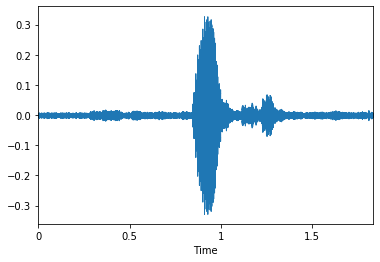

In [16]:
librosa.display.waveplot(add_noise(audio), sr=sr)

In [17]:
Audio(add_noise(audio), rate=sr)

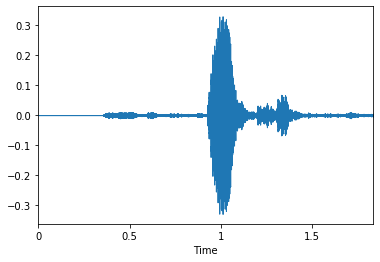

In [18]:
librosa.display.waveplot(shift(audio), sr=sr)

In [19]:
Audio(shift(audio), rate=sr)

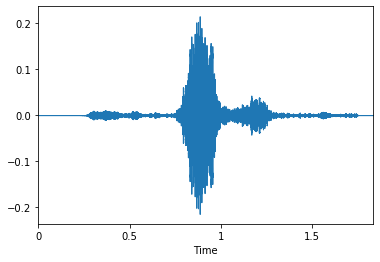

In [20]:
librosa.display.waveplot(stretch(audio), sr=sr)

In [21]:
Audio(stretch(audio), rate=sr)

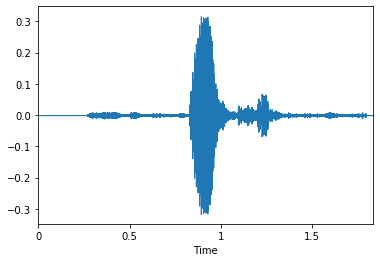

In [22]:
librosa.display.waveplot(pitch_and_speed(audio), sr=sr)

In [23]:
Audio(pitch_and_speed(audio), rate=sr)

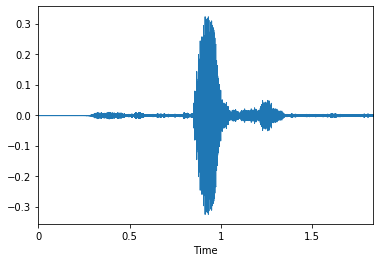

In [24]:
librosa.display.waveplot(pitch(audio), sr=sr)

In [25]:
Audio(pitch(audio), rate=sr)

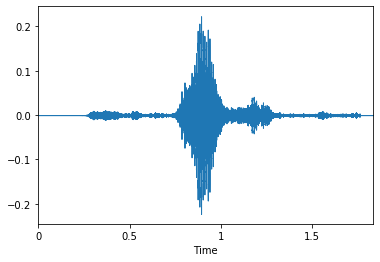

In [26]:
librosa.display.waveplot(speed(audio), sr=sr)

In [27]:
Audio(speed(audio), rate=sr)

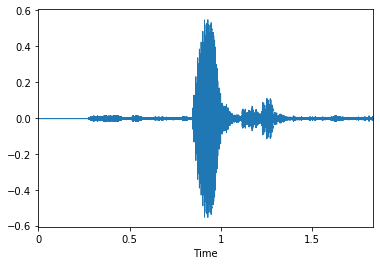

In [28]:
librosa.display.waveplot(augmentation(audio), sr=sr)

In [29]:
Audio(augmentation(audio), rate=sr)

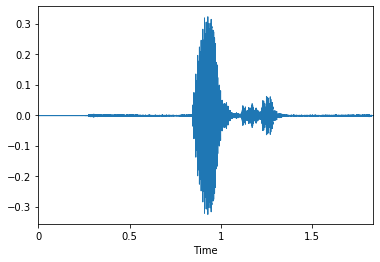

In [30]:
librosa.display.waveplot(hpps(audio), sr=sr)

In [31]:
Audio(hpps(audio), rate=sr)

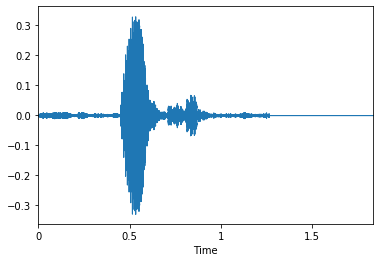

In [32]:
librosa.display.waveplot(silent_to_the_right(audio), sr=sr)

In [33]:
Audio(silent_to_the_right(audio), rate=sr)

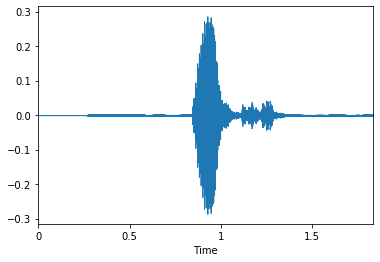

In [34]:
librosa.display.waveplot(remove_noise(audio), sr=sr)

In [35]:
Audio(remove_noise(audio), rate=sr)

In [36]:
def get_significant_part(data, length=16000, extra_length=5000):
    curr_data = data.copy()
    
    curr_data = np.concatenate((np.zeros((extra_length,), dtype=float), curr_data), axis=None)
    curr_data = np.concatenate((curr_data, np.zeros((extra_length,), dtype=float)), axis=None)
    if len(curr_data) <= length + 2 * extra_length:
        zeros = length - len(curr_data) + 3 + 2 * extra_length
        #curr_data = np.concatenate((np.zeros((10,), dtype=float), curr_data), axis=None)
        curr_data = np.concatenate((curr_data, np.zeros((zeros,), dtype=float)), axis=None)
    
    max_sum = 0
    result = curr_data[0:length + 2 * extra_length]
    for i in range(extra_length, length + extra_length):
        max_sum += abs(curr_data[i])
        
    curr_sum = max_sum
    for i in range(length + extra_length, len(curr_data) - extra_length):
        curr_sum += abs(curr_data[i])
        curr_sum -= abs(curr_data[i - length])
        
        if curr_sum > max_sum:
            max_sum = curr_sum
            result = curr_data[i - length - extra_length:i + extra_length]
    
    return result

In [37]:
def multiply_audio(audio):
    audios = []
    audios.append(audio)
    audios.append(add_noise(audio))
    
    audios.append(stretch(audio))
    audios.append(add_noise(stretch(audio)))
    
    audios.append(pitch_and_speed(audio))
    audios.append(add_noise(pitch_and_speed(audio)))
    
    audios.append(pitch(audio))
#     audios.append(add_noise(pitch(audio)))
    
    audios.append(speed(audio))
    audios.append(add_noise(speed(audio)))
    
    audios.append(augmentation(audio))
    audios.append(add_noise(augmentation(audio)))
    
    audios.append(hpps(audio))
    audios.append(add_noise(hpps(audio)))
    
    audios.append(silent_to_the_right(audio))
    audios.append(add_noise(silent_to_the_right(audio)))
    
    audios.append(remove_noise(audio))

    return [get_significant_part(audio) for audio in audios]

In [38]:
def load_data(path, test_data=False):
    labels, voices = [], []
    for dirpath, dirnames, filenames in os.walk(path):
        try:
            label = int(dirpath.split("/")[-1])
        except:
            pass

        for filename in filenames:
            audio, sr = lr.load(os.path.join(dirpath, filename), mono=True, sr=SR)

            augmented_voices = multiply_audio(audio) if not test_data else [get_significant_part(audio)]
            labels += [label] * len(augmented_voices)
            voices += augmented_voices
    return voices, labels

In [39]:
def pad_voices(voices, max_length):
    padded_voices = voices.copy()
    return list(map(lambda v: np.pad(v, (0, max_length - len(v)), mode="constant"), padded_voices))

In [40]:
def get_mfccs(voices):
    return [librosa.feature.mfcc(voice, sr=SR, n_mfcc=n_mfcc) for voice in voices]

In [41]:
voices, labels = load_data("./data")

(array([    0.,     0.,     0.,     0.,     0., 10160.,     0.,     0.,
            0.,     0.]),
 array([25999.5, 25999.6, 25999.7, 25999.8, 25999.9, 26000. , 26000.1,
        26000.2, 26000.3, 26000.4, 26000.5]),
 <a list of 10 Patch objects>)

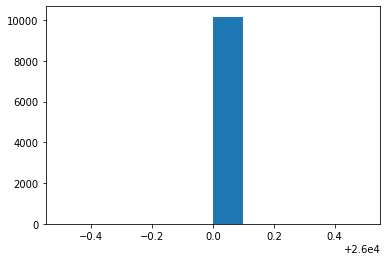

In [42]:
lengths = list(map(len, voices))
max_length = max(lengths)
lengths.sort()
plt.hist(lengths)

In [55]:
test_voices, test_labels = load_data("./cleanTest", test_data=True)

In [56]:
test_lengths = list(map(len, test_voices))
max_length = max(max_length, max(test_lengths))
max_length

26000

In [45]:
padded_voices = pad_voices(voices, max_length)
mfccs = get_mfccs(padded_voices)

In [57]:
max_mfcc_length = mfccs[0].shape[1]
max_mfcc_length

51

In [58]:
padded_test_voices = pad_voices(test_voices, max_length)
test_mfccs = get_mfccs(padded_test_voices)

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(mfccs, labels, train_size=0.8)
X_train, y_train = mfccs, labels
X_test, y_test = test_mfccs, test_labels

In [60]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_test = np.asarray([x[1:] for x in to_categorical(y_test)])
y_train = np.asarray([x[1:] for x in to_categorical(y_train)])

X_train = X_train.reshape(X_train.shape[0], n_mfcc, max_mfcc_length, 1)
X_test = X_test.reshape(X_test.shape[0], n_mfcc, max_mfcc_length, 1)

In [61]:
epochs = 20

In [62]:
model = Sequential()
model.add(Conv2D(16, 
                (5, 5),
                input_shape=(n_mfcc, max_mfcc_length, 1),
                activation="relu"))
model.add(Conv2D(32, 
                (3, 3),
                activation="relu"))
model.add(Conv2D(64, 
                (3, 3),
                activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(32, activation="relu"))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 6, 47, 16)         416       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 45, 32)         4640      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 43, 64)         18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 21, 64)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 21, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [63]:
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Train on 10160 samples, validate on 75 samples
Epoch 1/20
10160/10160 [==============================] - 12s 1ms/step - loss: 0.7761 - accuracy: 0.7033 - val_loss: 0.5345 - val_accuracy: 0.8400
Epoch 2/20
10160/10160 [==============================] - 14s 1ms/step - loss: 0.1452 - accuracy: 0.9527 - val_loss: 0.3681 - val_accuracy: 0.9067
Epoch 3/20
10160/10160 [==============================] - 19s 2ms/step - loss: 0.0704 - accuracy: 0.9801 - val_loss: 0.3429 - val_accuracy: 0.9067
Epoch 4/20
10160/10160 [==============================] - 17s 2ms/step - loss: 0.0482 - accuracy: 0.9842 - val_loss: 0.3676 - val_accuracy: 0.9200
Epoch 5/20
10160/10160 [==============================] - 14s 1ms/step - loss: 0.0279 - accuracy: 0.9912 - val_loss: 0.5614 - val_accuracy: 0.9067
Epoch 6/20
10160/10160 [==============================] - 18s 2ms/step - loss: 0.0434 - accuracy: 0.9862 - val_loss: 0.2746 - val_accuracy: 0.9333
Epoch 7/20
10160/10160 [==============================] - 18s 2ms/step 

In [ ]:
Audio(test_voices[120], rate=sr)

In [ ]:
test_labels[120]

In [ ]:
predictions = np.round(model.predict(X_test))
re_predictions = model.predict(X_test)
[i for (i, tup) in enumerate(zip(predictions, y_test)) if any(tup[0] != tup[1])]

In [ ]:
predictions[120]

In [ ]:
Audio(test_voices[22], rate=sr)

In [ ]:
y_test[0]

In [ ]:
librosa.display.waveplot(test_voices[25], sr=sr)

In [ ]:
y_test[25]

In [ ]:
# model_json = model.to_json()
# with open("result_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("result_model_weights.h5")